# Libraries:

In [ ]:
!pip install gym==0.21.0
!pip install stable-baselines3
!pip install torch
!pip install joblib
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

  Using cached gym-0.21.0.tar.gz (1.5 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import random
import math
from collections import deque
import os
import seaborn as sns

## Ensure reproducibility:

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

print("Environment is ready. Packages are loaded and seed is set.")

Environment is ready. Packages are loaded and seed is set.


# GLOBAL CONSTANTS

In [ ]:
GRID_SIZE = 30
ALPHA = 0.1
SIMULATIONS = 1000
MAX_SIMULATION_STEPS = 300 # Infinite loop prevention
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Initializing the Ship Layout:

## 1) Initializing the Ship Grid:

In [ ]:
def initialize_ship(grid_size=GRID_SIZE):
    grid = np.ones((grid_size, grid_size), dtype=int)
    grid[0, :] = 1
    grid[:, 0] = 1
    grid[-1, :] = 1
    grid[:, -1] = 1
    start_x, start_y = grid_size // 2, grid_size // 2
    grid[start_x, start_y] = 0
    walls = []
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        nx, ny = start_x + dx, start_y + dy
        if 1 <= nx < grid_size - 1 and 1 <= ny < grid_size - 1:
            walls.append((nx, ny))
    while walls:
        wx, wy = walls.pop(random.randint(0, len(walls)-1))
        adjacent_open = 0
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = wx+dx, wy+dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size and grid[nx, ny] == 0:
                adjacent_open += 1
        if adjacent_open == 1:
            grid[wx, wy] = 0
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                nx, ny = wx+dx, wy+dy
                if 1 <= nx < grid_size-1 and 1 <= ny < grid_size-1 and grid[nx, ny] == 1:
                    walls.append((nx, ny))
    return grid

print("Ship grid is now initialized.")

Ship grid is now initialized.


## 2) Manhattan Distance Function:

In [ ]:
def manhattan_distance(cell1, cell2):
    return abs(cell1[0] - cell2[0]) + abs(cell1[1] - cell2[1])

## 3) Ping Probability Function:

In [ ]:
def ping_prob(distance, alpha):
    return math.exp(-alpha * (distance - 1)) if distance > 0 else 1.0

## 4) Rat Detector Function:

In [ ]:
def rat_detector(bot_pos, rat_pos, alpha):
    distance = manhattan_distance(bot_pos, rat_pos)
    prob = ping_prob(distance, alpha)
    return random.random() < prob

## 5) Update Probabilities Function:

In [ ]:
def update_prob(prob_grid, bot_pos, heard_ping, alpha, grid):
    new_prob_grid = np.zeros_like(prob_grid)
    total_prob = 0.0
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if grid[x, y] == 0:
                dist = manhattan_distance(bot_pos, (x, y))
                prob_ping = ping_prob(dist, alpha)
                if heard_ping:
                    new_prob_grid[x, y] = prob_grid[x, y] * prob_ping
                else:
                    new_prob_grid[x, y] = prob_grid[x, y] * (1 - prob_ping)
                total_prob += new_prob_grid[x, y]
    if total_prob > 0:
        new_prob_grid /= total_prob
    return new_prob_grid

## 6) Path Finding Algorithm:

In [ ]:
def bfs_reachable(grid, start, goal):
    if start == goal:
        return True
    visited = set()
    queue = deque([start])
    visited.add(start)
    moves = [(0,1),(0,-1),(1,0),(-1,0)]
    while queue:
        current = queue.popleft()
        for dx, dy in moves:
            nx, ny = current[0] + dx, current[1] + dy
            neighbor = (nx, ny)
            if (0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and
                grid[nx, ny] == 0 and neighbor not in visited):
                if neighbor == goal:
                    return True
                visited.add(neighbor)
                queue.append(neighbor)
    return False

def bfs_length(grid, start, goal):
    if start == goal:
        return 0
    visited = set([start])
    queue = deque([(start,0)])
    moves = [(0,1),(0,-1),(1,0),(-1,0)]
    while queue:
        current, dist = queue.popleft()
        for dx, dy in moves:
            nx, ny = current[0]+dx, current[1]+dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and grid[nx, ny] == 0:
                if (nx, ny) == goal:
                    return dist + 1
                if (nx, ny) not in visited:
                    visited.add((nx, ny))
                    queue.append(((nx, ny), dist+1))
    return None

## 7) sense_distances function:

In [ ]:
def sense_distances(grid, position, rat_pos):
    return manhattan_distance(position, rat_pos)

## 8) random_move function:

In [ ]:
def random_move(grid, current_position):
    directions = [(0,1),(0,-1),(1,0),(-1,0)]
    random.shuffle(directions)
    for dx, dy in directions:
        nx, ny = current_position[0]+dx, current_position[1]+dy
        if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and grid[nx, ny] == 0:
            return (nx, ny)
    return current_position

## 9) Updating Knowledge Base using build_distance_signatiures():

In [ ]:
def build_distance_signatures(grid, rat_position):
    distance_signatures = {}
    open_cells = [
        (x, y) for x in range(1, GRID_SIZE - 1) for y in range(1, GRID_SIZE - 1)
        if grid[x, y] == 0
    ]
    for cell in open_cells:
        d = manhattan_distance(cell, rat_position)
        if d not in distance_signatures:
            distance_signatures[d] = []
        distance_signatures[d].append(cell)
    return distance_signatures

## 10) Bot localization function:

In [ ]:
def localize_bot(grid, distance_signatures, rat_position, max_steps=500):
    all_positions = [loc for sig in distance_signatures.values() for loc in sig]
    if not all_positions:
        fallback = [
            (x,y) for x in range(1, GRID_SIZE-1) for y in range(1, GRID_SIZE-1)
            if grid[x, y] == 0
        ]
        return random.choice(fallback) if fallback else (1,1)
    random.shuffle(all_positions)
    current_position = random.choice(all_positions)
    steps = 0
    while steps < max_steps:
        sensed_signature = sense_distances(grid, current_position, rat_position)
        if sensed_signature in distance_signatures:
            possible_positions = distance_signatures[sensed_signature]
            if len(possible_positions) == 1:
                return possible_positions[0]
            new_position = random_move(grid, current_position)
            if new_position == current_position:
                current_position = random.choice(possible_positions)
            else:
                current_position = new_position
        else:
            current_position = random_move(grid, current_position)
        steps += 1
    open_cells = [
        (x, y) for x in range(1, GRID_SIZE -1) for y in range(1, GRID_SIZE -1)
        if grid[x, y] ==0
    ]
    return random.choice(open_cells) if open_cells else (1,1)

# DATA COLLECTION

In [ ]:
def data_collection(num_simulations=SIMULATIONS, alpha=ALPHA,output_file='data/training_data.csv', summary_file='data/simulation_summary.csv'):
  data = []
  simulation_summaries = []
  fixed_grid = initialize_ship(GRID_SIZE)
  print("Starting data collection...")

  for simulation_id in range(num_simulations):
      print(f"\rSimulation {simulation_id + 1}/{num_simulations}", end="")
      grid = fixed_grid.copy()

      rat_position = random.choice([
          (x, y) for x in range(1, GRID_SIZE - 1) for y in range(1, GRID_SIZE - 1)
          if grid[x, y] == 0
      ])

      distance_signatures = build_distance_signatures(grid, rat_position)
      bot_position = localize_bot(grid, distance_signatures, rat_position=rat_position)

      if not bfs_reachable(grid, bot_position, rat_position):
          continue

      prob_grid = np.full((GRID_SIZE, GRID_SIZE), 1.0 / (GRID_SIZE * GRID_SIZE))
      shortest_path_steps_start = bfs_length(grid, bot_position, rat_position)
      if shortest_path_steps_start is None:
          continue
      simulation_summaries.append({
          'simulation_id': simulation_id + 1,
          'starting_position_x': bot_position[0],
          'starting_position_y': bot_position[1],
          'steps_remaining': float(shortest_path_steps_start)
      })

      simulation_data = []
      for step in range(MAX_SIMULATION_STEPS):
          heard_ping = rat_detector(bot_position, rat_position, alpha)
          prob_grid = update_prob(prob_grid, bot_position, heard_ping, alpha, grid)
          shortest_path_steps = bfs_length(grid, bot_position, rat_position)
          if shortest_path_steps is None:
              break

          simulation_data.append({'ship': grid.copy(),'knowledge': prob_grid.copy(),'steps': float(shortest_path_steps)})

          directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
          random.shuffle(directions)
          moved = False
          for dx, dy in directions:
              new_x, new_y = bot_position[0] + dx, bot_position[1] + dy
              if (0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE and
                  grid[new_x, new_y] == 0):
                  bot_position = (new_x, new_y)
                  moved = True
                  break
          if not moved:
              break

          if bot_position == rat_position:
              break

      if bot_position == rat_position:
          data.extend(simulation_data)

  print(f"\nTotal states collected: {len(data)}")
  print(f"Saving data to {output_file} and simulation summaries to {summary_file}...")
  os.makedirs(os.path.dirname(output_file), exist_ok=True)
  with open(output_file, 'w', newline='') as f:
      writer = csv.writer(f)
      for entry in data:
          ship_flat = entry['ship'].flatten().tolist()
          knowledge_flat = entry['knowledge'].flatten().tolist()
          combined_row = ship_flat + knowledge_flat + [entry['steps']]
          writer.writerow(combined_row)

  os.makedirs(os.path.dirname(summary_file), exist_ok=True)
  with open(summary_file, 'w', newline='') as f:
      writer = csv.writer(f)
      writer.writerow(['simulation_id', 'starting_position_x', 'starting_position_y', 'steps_remaining'])
      for summary in simulation_summaries:
          writer.writerow([
              summary['simulation_id'],
              summary['starting_position_x'],
              summary['starting_position_y'],
              summary['steps_remaining']
          ])
  return data, simulation_summaries

In [ ]:
# Run data collection
data, simulation_summaries = data_collection()
print("Data collection complete.")

Starting data collection...
Simulation 1000/1000
Total states collected: 7811
Saving data to data/training_data.csv and simulation summaries to data/simulation_summary.csv...
Data collection complete.


# Neural Network Model

In [ ]:
class RatDataset(Dataset):
    def __init__(self, filename, summary_filename=None, subset='all'):
        self.data = []
        self.summary = {}
        if summary_filename and subset in ['test', 'all']:
            with open(summary_filename, 'r') as f:
                reader = csv.DictReader(f)
                for row in reader:
                    sim_id = int(row['simulation_id'])
                    self.summary[sim_id] = {
                        'starting_position_x': int(row['starting_position_x']),
                        'starting_position_y': int(row['starting_position_y']),
                        'steps_remaining': float(row['steps_remaining'])
                    }

        with open(filename, 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                row = [float(x) for x in row]
                ship = torch.tensor(row[:GRID_SIZE*GRID_SIZE], dtype=torch.float32).reshape(1, GRID_SIZE, GRID_SIZE)
                knowledge = torch.tensor(row[GRID_SIZE*GRID_SIZE:-1], dtype=torch.float32).reshape(1, GRID_SIZE, GRID_SIZE)
                target = torch.tensor([row[-1]], dtype=torch.float32)
                input_tensor = torch.cat([ship, knowledge], dim=0)
                self.data.append((input_tensor, target))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
class StepPredictor(nn.Module):
    #CNN Model
    def __init__(self):
        super(StepPredictor, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        conv_output_size = 256 * (GRID_SIZE // 16) * (GRID_SIZE // 16)
        self.fc = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# MODEL TRAINING

In [ ]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs,
               train_loss_file='train_losses.txt', val_loss_file='val_losses.txt', test_loss_file='test_losses.txt'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Using device: {device}")

    best_val_loss = float('inf')

    # for opening loss files
    with open(train_loss_file, 'w') as train_file, \
         open(val_loss_file, 'w') as val_file, \
         open(test_loss_file, 'w') as test_file:

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)
            train_file.write(f"{train_loss}\n")

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
            val_loss /= len(val_loader)
            val_file.write(f"{val_loss}\n")

            # Evaluate on test set
            test_loss = 0.0
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    test_loss += loss.item()
            test_loss /= len(test_loader)
            test_file.write(f"{test_loss}\n")

            print(f'\nEpoch {epoch+1}/{num_epochs}:')
            print(f'Training Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}')
            print(f'Test Loss: {test_loss:.4f}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'steps_remaining.pth')
                print(f'--> Model saved with validation loss: {val_loss:.4f}')

# Graph Analysis Functions:

## 1) plot_losses():

In [ ]:
def plot_losses_train(train_loss_file='train_losses.txt'):
    with open(train_loss_file, 'r') as f:
        train_losses = [float(line.strip()) for line in f.readlines()]
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_losses_validation(val_loss_file='val_losses.txt'):
    with open(val_loss_file, 'r') as f:
        val_losses = [float(line.strip()) for line in f.readlines()]
    epochs = range(1, len(val_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_losses, label='Validation Loss', marker='s', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_losses_test(test_loss_file='test_losses.txt'):
    with open(test_loss_file, 'r') as f:
        test_losses = [float(line.strip()) for line in f.readlines()]
    epochs = range(1, len(test_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, test_losses, label='Test Loss', marker='^', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.tight_layout()
    plt.show()

## 2) plot_loss_vs_steps_remaining():

In [ ]:
def plot_loss_vs_steps_remaining(model_path='steps_remaining.pth', test_loader=None, grid_size=GRID_SIZE):
    if test_loader is None:
        raise ValueError("Test loader must be provided.")
    model = StepPredictor()
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    criterion = nn.MSELoss(reduction='none')
    all_steps = []
    all_losses = []
    with torch.no_grad():
        for inputs, targets in test_loader:
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss = loss.cpu().numpy().flatten()
          steps = targets.cpu().numpy().flatten()
          all_steps.extend(steps)
          all_losses.extend(loss)
    all_steps = np.array(all_steps)
    all_losses = np.array(all_losses)
    bins = np.linspace(all_steps.min(), all_steps.max(), 50)
    bin_indices = np.digitize(all_steps, bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_means = []
    bin_stds = []
    for i in range(1, len(bins)):
        bin_losses = all_losses[bin_indices == i]
        if len(bin_losses) > 0:
            bin_means.append(bin_losses.mean())
            bin_stds.append(bin_losses.std())
        else:
            bin_means.append(np.nan)
            bin_stds.append(np.nan)
    bin_means = np.array(bin_means)
    bin_stds = np.array(bin_stds)
    plt.figure(figsize=(12, 7))
    plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', ecolor='r', capthick=2, capsize=4, markersize=5, label='Average Loss per Bin')
    plt.xlabel('Steps Remaining')
    plt.ylabel('Loss (MSE)')
    plt.title('Average Loss as a Function of Steps Remaining')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 3) plot_loss_vs_steps_remaining_violin():

In [ ]:
def plot_loss_vs_steps_remaining_violin(model_path='steps_remaining.pth', test_loader=None, grid_size=GRID_SIZE):
    if test_loader is None:
        raise ValueError("Test loader must be provided.")
    model = StepPredictor()
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    criterion = nn.MSELoss(reduction='none')
    all_steps = []
    all_losses = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss = loss.cpu().numpy().flatten()
            steps = targets.cpu().numpy().flatten()
            all_steps.extend(steps)
            all_losses.extend(loss)
    all_steps = np.array(all_steps)
    all_losses = np.array(all_losses)
    df = pd.DataFrame({'Steps Remaining': all_steps,'Loss (MSE)': all_losses})
    plt.figure(figsize=(14, 8))
    sns.violinplot(x='Steps Remaining', y='Loss (MSE)', data=df, density_norm='width', inner='quartile')
    plt.xlabel('Steps Remaining')
    plt.ylabel('Loss (MSE)')
    plt.title('Distribution of Loss as a Function of Steps Remaining')
    plt.tight_layout()
    plt.show()

## 4) print_steps_remaining_per_simulation():

In [ ]:
def print_steps_remaining_per_simulation(test_loader, simulation_summary_file='data/simulation_summary.csv', test_dataset_size=None):
    simulation_summaries = []
    with open(simulation_summary_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            simulation_summaries.append({
                'simulation_id': int(row['simulation_id']),
                'starting_position_x': int(row['starting_position_x']),
                'starting_position_y': int(row['starting_position_y']),
                'steps_remaining': float(row['steps_remaining'])
            })
    total_simulations = len(simulation_summaries)
    train_size = int(0.7 * total_simulations)
    val_size = int(0.15 * total_simulations)
    test_size = total_simulations - train_size - val_size
    test_summaries = simulation_summaries[train_size + val_size:]

    print("\n--- Steps Remaining per Simulation in Test Set ---")
    for summary in test_summaries:
        print(f"Simulation {summary['simulation_id']}: Starting Position = ({summary['starting_position_x']}, {summary['starting_position_y']}), Steps Remaining = {summary['steps_remaining']}")
    print("--- End of Simulation Summaries ---\n")

# MAIN FUNCTION

In [ ]:
def main():
    dataset_file_local = 'data/training_data.csv'
    summary_file_local = 'data/simulation_summary.csv'

    dataset = RatDataset(dataset_file_local, summary_filename=summary_file_local, subset='all')
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    print("\nTraining model...")
    model = StepPredictor()

    # Check if a saved model exists and load it
    model_path = 'steps_remaining.pth'
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print("Loaded existing model.")
    else:
        print("No existing model found. Initializing a new model.")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train and save losses to files
    train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, EPOCHS)

    print("Training complete! For further training re-run again.")
    return test_loader

In [ ]:
test_loader = main()


Training model...
No existing model found. Initializing a new model.
Using device: cpu

Epoch 1/20:
Training Loss: 41.9540
Validation Loss: 39.9865
Test Loss: 38.7382
--> Model saved with validation loss: 39.9865

Epoch 2/20:
Training Loss: 36.7724
Validation Loss: 34.3802
Test Loss: 33.6899
--> Model saved with validation loss: 34.3802

Epoch 3/20:
Training Loss: 36.1053
Validation Loss: 37.3710
Test Loss: 37.2066

Epoch 4/20:
Training Loss: 36.3210
Validation Loss: 34.1038
Test Loss: 33.3026
--> Model saved with validation loss: 34.1038

Epoch 5/20:
Training Loss: 34.3401
Validation Loss: 27.1572
Test Loss: 26.3399
--> Model saved with validation loss: 27.1572

Epoch 6/20:
Training Loss: 25.7051
Validation Loss: 22.1781
Test Loss: 21.2087
--> Model saved with validation loss: 22.1781

Epoch 7/20:
Training Loss: 21.4630
Validation Loss: 22.0955
Test Loss: 20.6025
--> Model saved with validation loss: 22.0955

Epoch 8/20:
Training Loss: 19.0127
Validation Loss: 15.5474
Test Loss: 14.4

# Graph Analysis:

## 1) Training Loss Over Epochs:

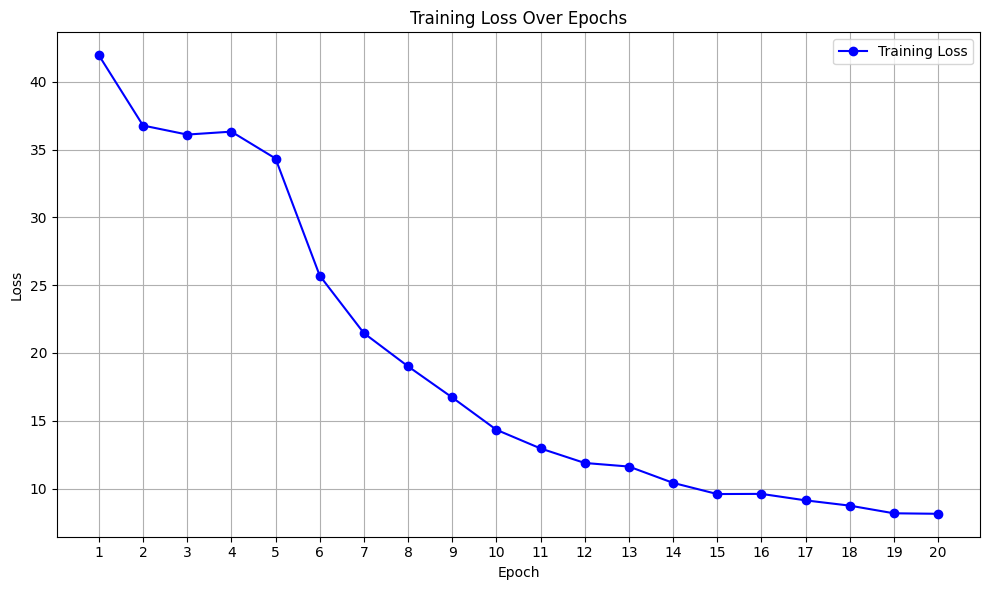

In [ ]:
plot_losses_train(train_loss_file='train_losses.txt')

## 2) VAL Loss over Epochs()

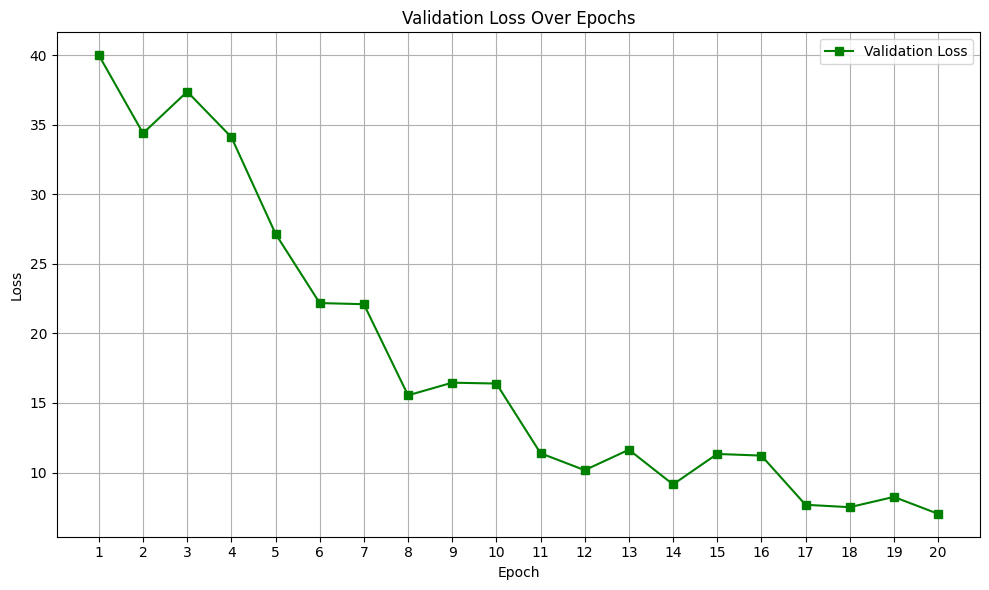

In [ ]:
plot_losses_validation(val_loss_file='val_losses.txt')

## 3) Test Loss over Epochs()

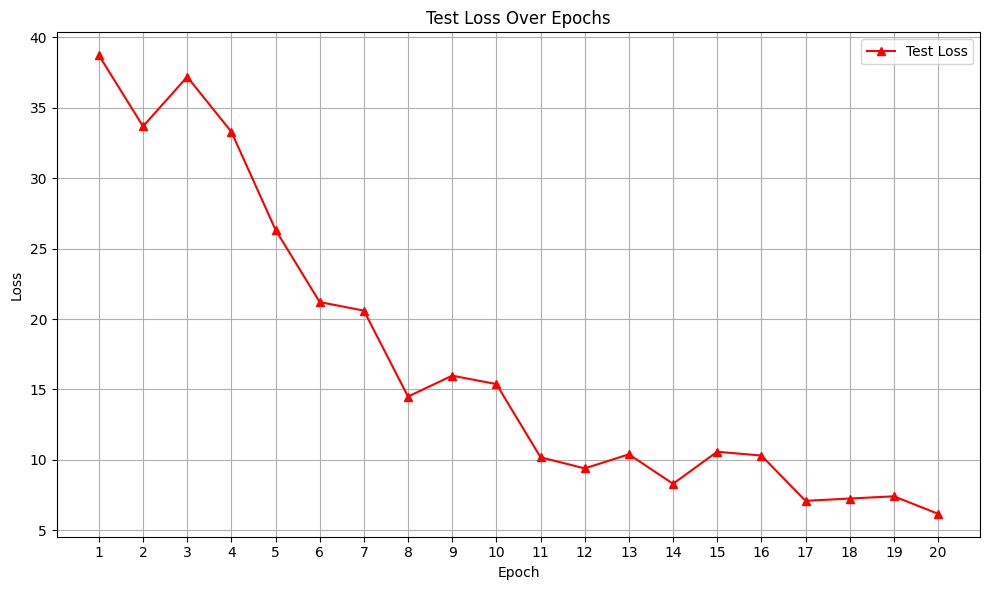

In [ ]:
plot_losses_test(test_loss_file='test_losses.txt')

## 4) Average Loss as a Function of Steps Remaining:

<ipython-input-23-e215d8893716>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


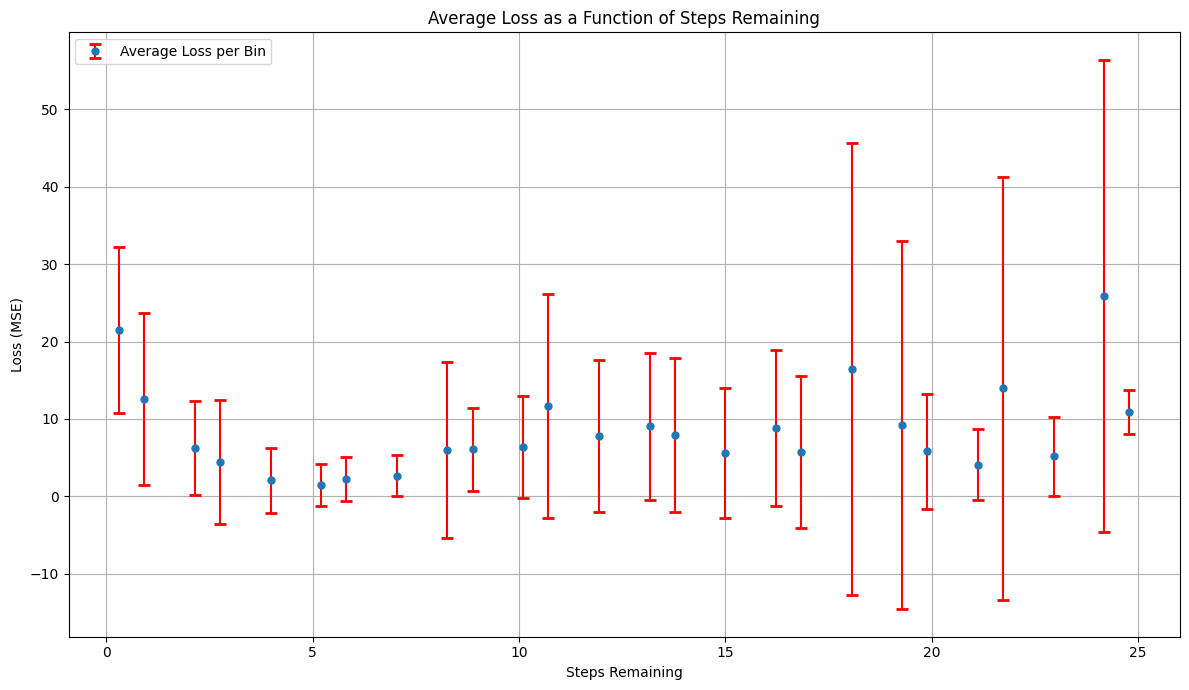

In [ ]:
plot_loss_vs_steps_remaining(model_path='steps_remaining.pth', test_loader=test_loader, grid_size=GRID_SIZE)

## 5) Violin plot of loss distribution vs steps remaining

<ipython-input-24-e1a12f30d019>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


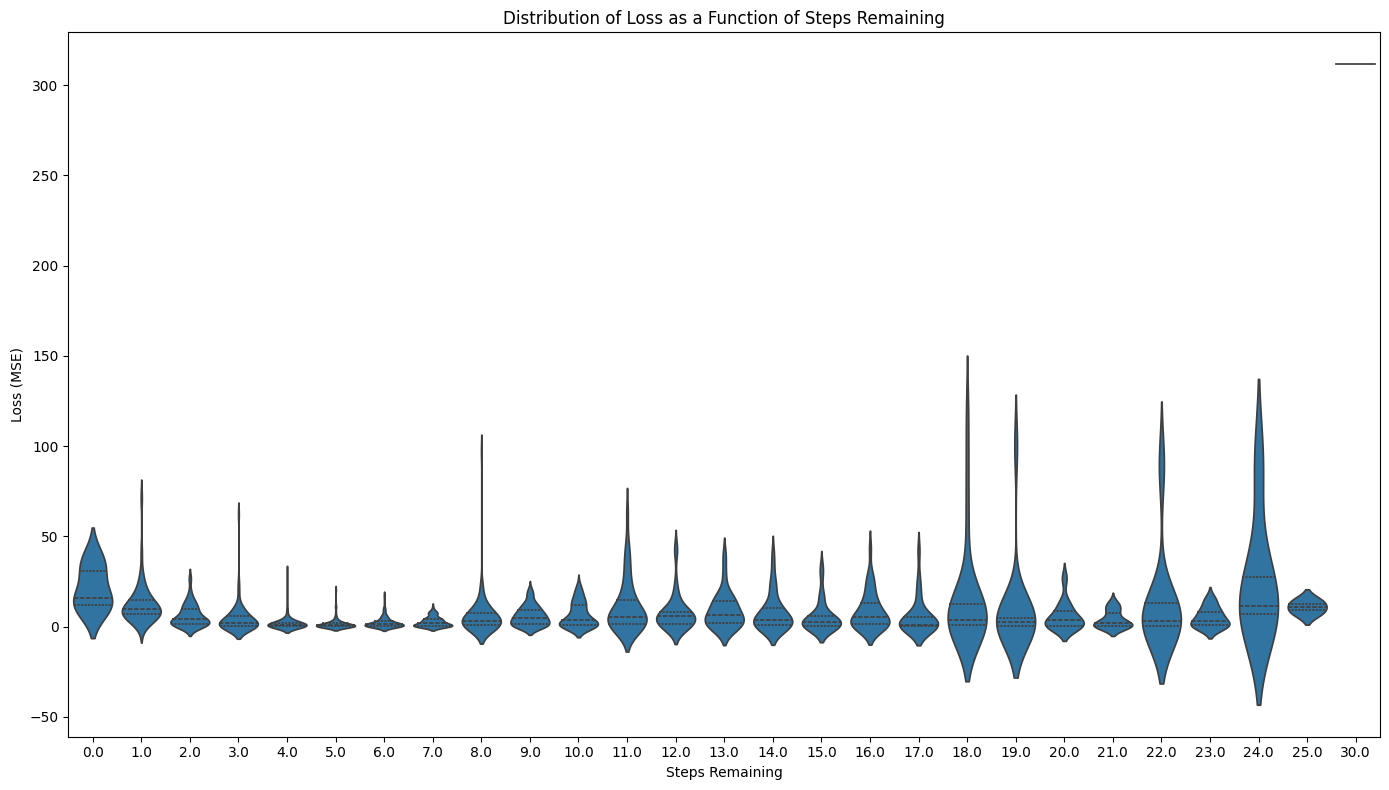

In [ ]:
plot_loss_vs_steps_remaining_violin(model_path='steps_remaining.pth', test_loader=test_loader, grid_size=GRID_SIZE)

## 6) Steps remaining per simulation in the test set

In [ ]:
print_steps_remaining_per_simulation(test_loader, simulation_summary_file='data/simulation_summary.csv', test_dataset_size=None)


--- Steps Remaining per Simulation in Test Set ---
Simulation 851: Starting Position = (19, 17), Steps Remaining = 25.0
Simulation 852: Starting Position = (26, 21), Steps Remaining = 14.0
Simulation 853: Starting Position = (4, 5), Steps Remaining = 34.0
Simulation 854: Starting Position = (24, 7), Steps Remaining = 29.0
Simulation 855: Starting Position = (23, 9), Steps Remaining = 30.0
Simulation 856: Starting Position = (27, 27), Steps Remaining = 42.0
Simulation 857: Starting Position = (27, 3), Steps Remaining = 24.0
Simulation 858: Starting Position = (26, 22), Steps Remaining = 30.0
Simulation 859: Starting Position = (8, 22), Steps Remaining = 42.0
Simulation 860: Starting Position = (15, 13), Steps Remaining = 16.0
Simulation 861: Starting Position = (14, 16), Steps Remaining = 22.0
Simulation 862: Starting Position = (11, 25), Steps Remaining = 37.0
Simulation 863: Starting Position = (7, 14), Steps Remaining = 28.0
Simulation 864: Starting Position = (26, 21), Steps Remain